In [1]:
from platform import python_version

python_version()

'3.9.9'

In [2]:
from glob import glob

from osgeo import gdal

import rasterio as rio
from rasterio.plot import show_hist
from pyroSAR import identify

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

import plotly.graph_objects as go

import cv2
import skimage.exposure

### SAR

Filename `RS2-SGF-SLA3-ASC-27-Dec-2019_17.09-KNOS_31993809_Cal_Spk_ML_TC_jaxa_CLIPPED.tif`

- **RADARSAT-2** (RS2)
- **SGF**, Detected (magnitude) data. Ground-range geometry (no phase information). Georeferenced (path image) - generated with standard ground-coordinate pixel dimensions
- **SLA3**, Spotlight imaging mode with multiple beams at varying incidence angles, single polarization (HH or HV or VH or VV)
- **ASC**, Ascending

Processing (from filename)
- (**Cal**) Radiometric calibration (pixels directly related to backscatter)
- (**Spk**) Speckle filter
- (**ML**) Multilooked
- (**TC**) Terrain correction / Geometric calibration
- Pixels converted to dB (from sigma0)

Q's

- Which polarization?
- Is the processing steps already applied to Askvoll image?
- C-band?

In [3]:
optical_images = glob("data/optical_Askvoll/GeoEye-1/*.tif")
SAR_images = glob("data/SAR_Askvoll/SAR/*.tif")

opt_ds = rio.open(optical_images[1])
sar_ds = rio.open(SAR_images[0])

opt = opt_ds.read()
sar = sar_ds.read()



In [4]:
opt_cv2 = cv2.imread(optical_images[1])

In [5]:
gray = cv2.cvtColor(opt_cv2, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)[1]

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, borderType=cv2.BORDER_CONSTANT, borderValue=0)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel, borderType=cv2.BORDER_CONSTANT, borderValue=0)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
morph = cv2.morphologyEx(morph, cv2.MORPH_ERODE, kernel, borderType=cv2.BORDER_CONSTANT, borderValue=0)

contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key=cv2.contourArea)

contour = np.zeros_like(gray)
cv2.drawContours(contour, [big_contour], 0, 255, -1)

# blur dilate image
blur = cv2.GaussianBlur(contour, (5,5), sigmaX=0, sigmaY=0, borderType = cv2.BORDER_DEFAULT)

# stretch so that 255 -> 255 and 127.5 -> 0
mask = skimage.exposure.rescale_intensity(blur, in_range=(127.5,255), out_range=(0,255))

# put mask into alpha channel of input
result = cv2.cvtColor(opt_cv2, cv2.COLOR_BGR2BGRA)
result[:,:,3] = mask
print(result.shape)

(8239, 9266, 4)


# Meta data

**Optical**

In [6]:
print(f'Shape: \t\t{opt.shape} with data types {opt_ds.dtypes}')
print(f'Data types: \t{opt_ds.dtypes}')
print(f'Resolution: \t{opt_ds.res}')
print(f'Bounds: \t{opt_ds.bounds}')
epsg = str(opt_ds.crs).split(':')[1]
print(f'Proj4: \t\t{et.epsg[epsg]}')
print()
for k in opt_ds.meta:
    v = str(opt_ds.meta[k])
    print(f'{k : <10}: {v : <10}')






Shape: 		(3, 8239, 9266) with data types ('uint8', 'uint8', 'uint8')
Data types: 	('uint8', 'uint8', 'uint8')
Resolution: 	(1.0, 1.0)
Bounds: 	BoundingBox(left=289150.0, bottom=6804021.4, right=298416.0, top=6812260.4)
Proj4: 		+proj=utm +zone=32 +datum=WGS84 +units=m +no_defs

driver    : GTiff     
dtype     : uint8     
nodata    : None      
width     : 9266      
height    : 8239      
count     : 3         
crs       : EPSG:32632
transform : | 1.00, 0.00, 289150.00|
| 0.00,-1.00, 6812260.40|
| 0.00, 0.00, 1.00|


In [7]:
print(f'Shape: \t\t{sar.shape} with data types {sar_ds.dtypes}')
print(f'Data types: \t{sar_ds.dtypes}')
print(f'Resolution: \t{sar_ds.res}')
print(f'Bounds: \t{sar_ds.bounds}')
epsg = str(sar_ds.crs).split(':')[1]
print(f'Proj4: \t\t{et.epsg[epsg]}')
print()
for k in sar_ds.meta:
    v = str(sar_ds.meta[k])
    print(f'{k : <10}: {v : <10}')

Shape: 		(1, 5910, 8285) with data types ('float32',)
Data types: 	('float32',)
Resolution: 	(1.0, 1.0)
Bounds: 	BoundingBox(left=289618.70833304606, bottom=6804640.725289596, right=297903.70833304606, top=6810550.725289596)
Proj4: 		+proj=utm +zone=32 +datum=WGS84 +units=m +no_defs

driver    : GTiff     
dtype     : float32   
nodata    : None      
width     : 8285      
height    : 5910      
count     : 1         
crs       : EPSG:32632
transform : | 1.00, 0.00, 289618.71|
| 0.00,-1.00, 6810550.73|
| 0.00, 0.00, 1.00|


# Optical image

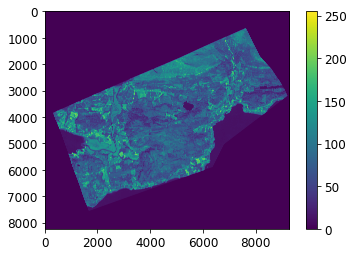

In [8]:
plt.imshow(opt[0, ...])
plt.colorbar()

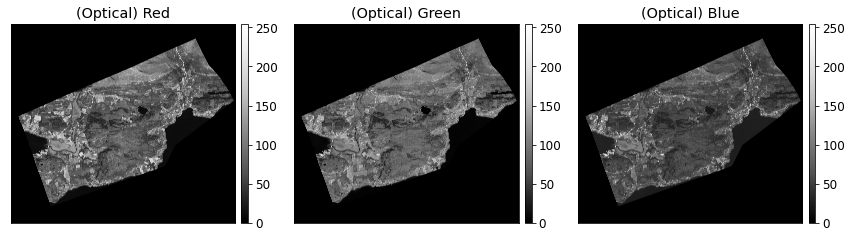

In [9]:
titles = ["(Optical) Red", "(Optical) Green", "(Optical) Blue"]
ep.plot_bands(opt, title=titles)
plt.show()

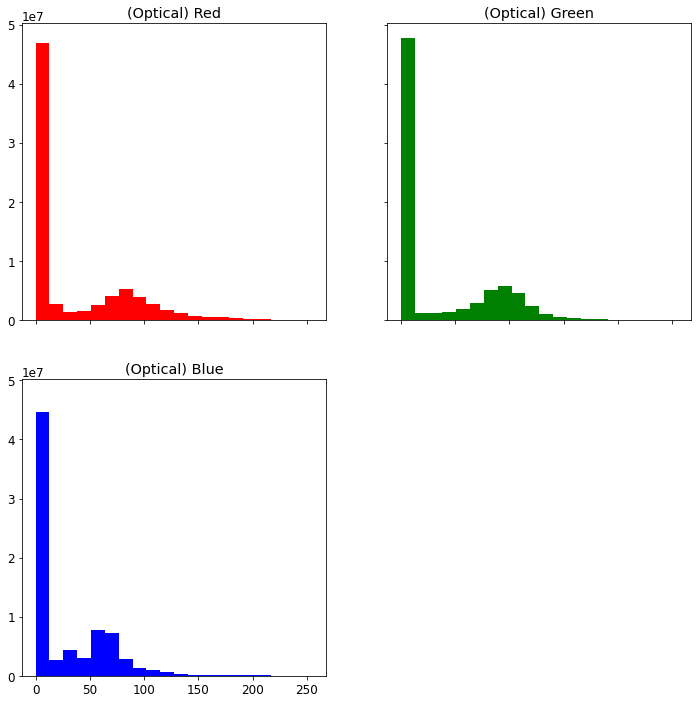

In [10]:
colors_list = [
    "Red",
    "Green",
    "Blue"
]
titles = ["(Optical) Red", "(Optical) Green", "(Optical) Blue"]

ep.hist(opt, colors=colors_list, title=titles)
plt.show()



### "Nodata" pixels with value `0` -> `np.nan`

The "nodata" pixels misrepresent the true distribution of valid pixel values within the dataset. Assigning "nodata" pixels that are outside the actual satellite image presents a true representation of the pixel value distribution across all bands.

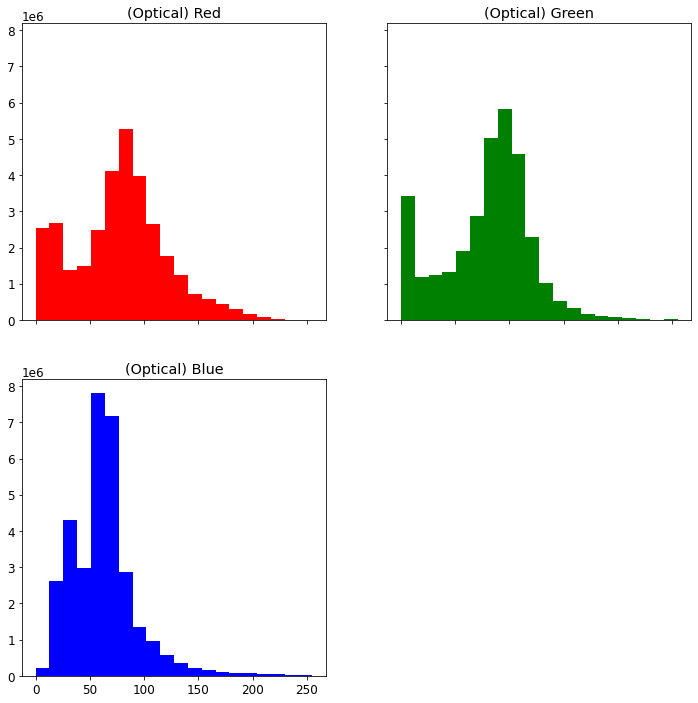

In [11]:
def nodata_as_nan(img):
    arr = img.copy()
    # np.nan requires float data type
    arr = arr.astype(np.float32)
    mask = np.all(arr == 0, axis=0)
    arr[:,mask] = np.nan
    return arr

colors_list = [
    "Red",
    "Green",
    "Blue"
]
titles = ["(Optical) Red", "(Optical) Green", "(Optical) Blue"]

opt_nan = nodata_as_nan(opt)

ep.hist(opt_nan, colors=colors_list, title=titles)
plt.show()


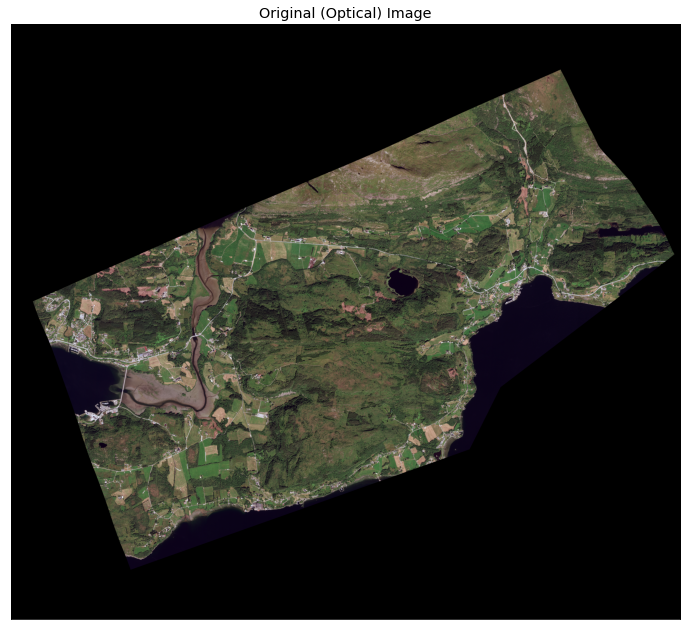

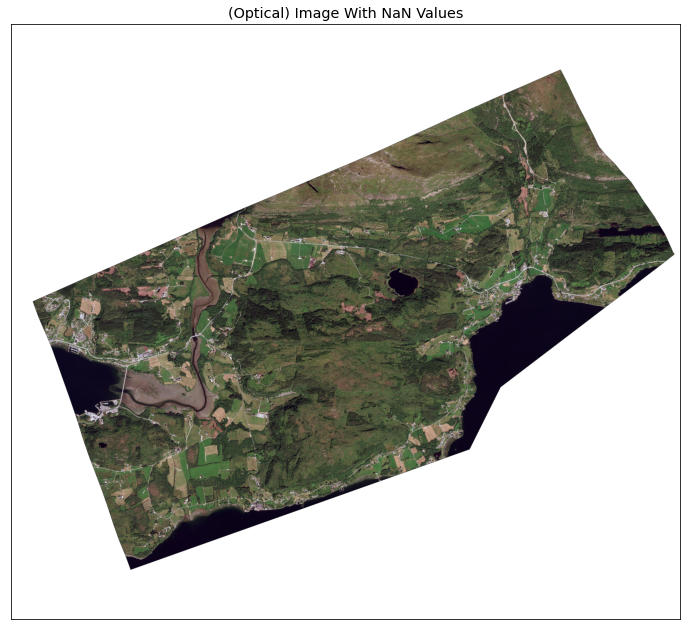

In [12]:
fig, ax = plt.subplots(figsize=(12, 12))
ep.plot_rgb(
    opt,
    ax=ax,
    title="Original (Optical) Image",
)
plt.show()


fig, ax = plt.subplots(figsize=(12, 12))
ep.plot_rgb(
    opt_nan,
    ax=ax,
    title="(Optical) Image With NaN Values",
)
plt.show()

# SAR image

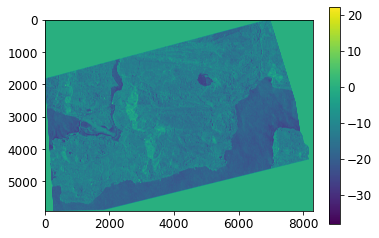

In [13]:
# color range implies dB values
plt.imshow(sar[0, ...])
plt.colorbar()

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'(SAR) Amplitude'}>)

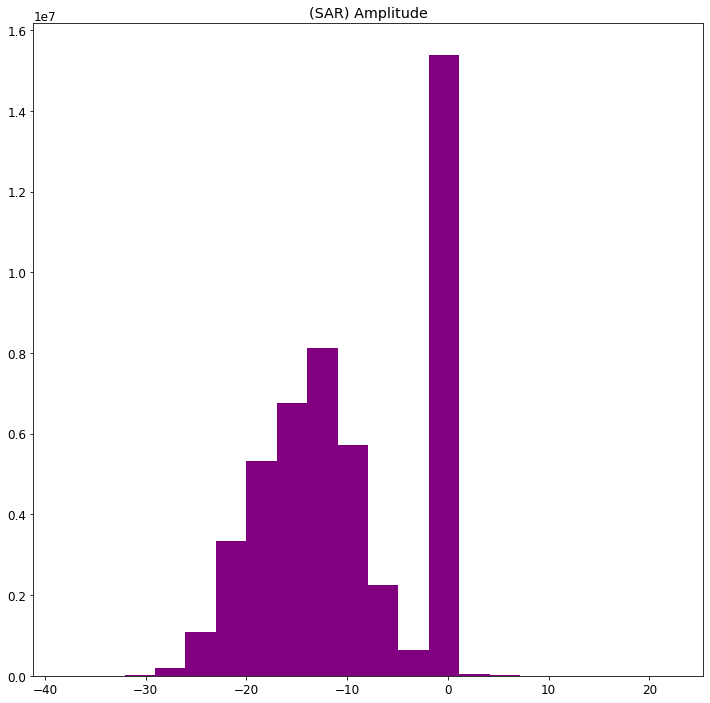

In [14]:
ep.hist(sar, colors=["Purple"], title=["(SAR) Amplitude"])

### "Nodata" pixels with value `0` -> `np.nan`

Since the data type is `float` the large range of possible values makes it so that basically no internal and valid pixels are *extactly* `0` and thus locating all "nodata" pixels is simply checking for `0`

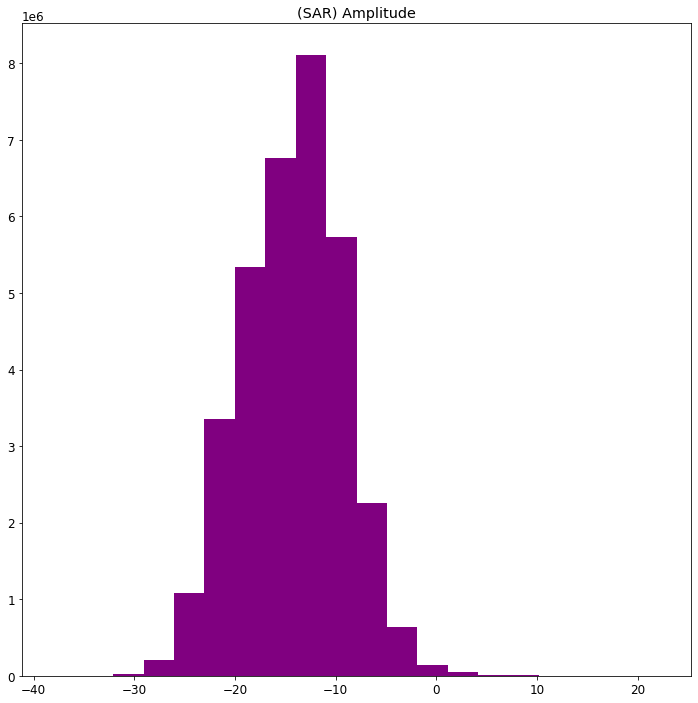

In [15]:
sar_nan = nodata_as_nan(sar)

ep.hist(sar_nan, colors=["Purple"], title=["(SAR) Amplitude"])
plt.show()

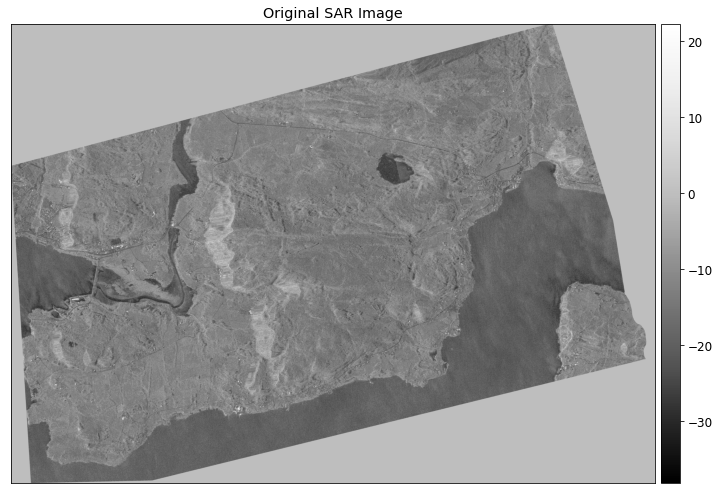

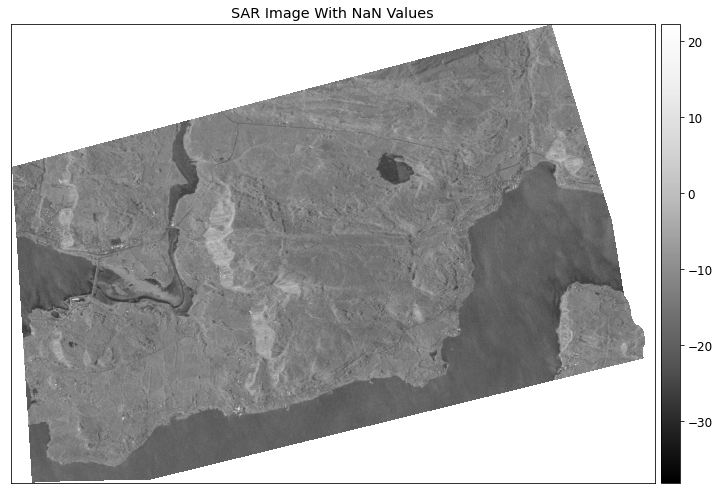

In [16]:
ep.plot_bands(sar, cbar=True, title="Original SAR Image")
plt.show()

ep.plot_bands(sar_nan, cbar=True, title="SAR Image With NaN Values")
plt.show()

## Comparing optical and SAR image

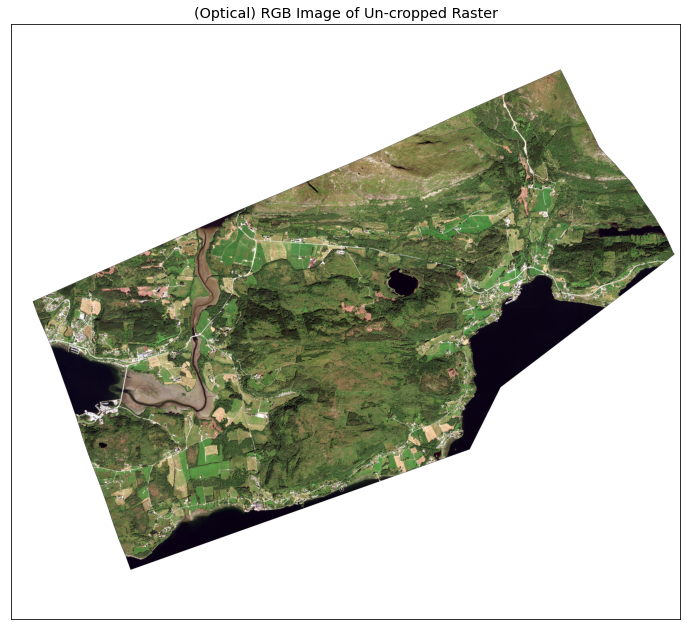

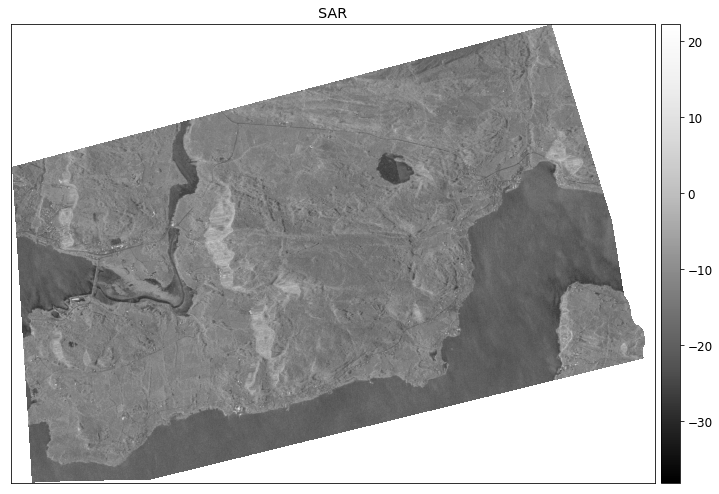

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))
ep.plot_rgb(
    opt_nan,
    ax=ax,
    stretch=True,
    str_clip=0.5,
    title="(Optical) RGB Image of Un-cropped Raster",
)
plt.show()

ep.plot_bands(sar_nan, cbar=True, title="SAR") # scale=True scale values to 0-255 range
plt.show()

In [18]:
from rasterio.coords import BoundingBox

# Create a minimal BoundingBox of two datasets
def minBox(ds1, ds2):
    left = max(ds1.bounds.left, ds2.bounds.left)
    right = min(ds1.bounds.right, ds2.bounds.right)
    top = min(ds1.bounds.top, ds2.bounds.top)
    bottom = max(ds1.bounds.bottom, ds2.bounds.bottom)
    return BoundingBox(left, bottom, right, top)

box = minBox(sar_ds, opt_ds)
box

BoundingBox(left=289618.70833304606, bottom=6804640.725289596, right=297903.70833304606, top=6810550.725289596)

## Comparing a patch from the same area

In [19]:
# IGNORE - old function
def sample_image_unscaled(opt_dataset, sar_dataset, boundingbox, h, w):

    #coordinates
    left_pos = 290468
    top_pos = 6807020
    
    # start row, column indices for the specified coordinates
    r_opt, c_opt = opt_dataset.index(left_pos, top_pos)
    r_sar, c_sar = sar_dataset.index(left_pos, top_pos)
    print(f'Optical, index [{r_opt},{c_opt}] from ({left_pos}, {top_pos})')
    print(f'SAR, index [{r_sar},{c_sar}] from ({left_pos}, {top_pos})')
    
    # extract the area (:,h,w)
    # different resolution means the subsets vary in size
    opt_subset = opt[:,r_opt:r_opt+h,c_opt:c_opt+w]
    sar_subset = sar[:,r_sar:r_sar+int(h//2.5),c_sar:c_sar+int(w//2.5)]
    
    print(f'Optical, index [{r_opt},{c_opt}] from ({left_pos}, {top_pos}) -> Shape {opt_subset.shape}')
    print(f'SAR, index [{r_sar},{c_sar}] from ({left_pos}, {top_pos}) -> Shape {sar_subset.shape}')
    
    return (opt_subset, sar_subset)

#opt_subset, sar_subset = sample_image_unscaled(opt_ds, sar_ds, box, 100, 100)

In [20]:
def sample_image(opt_dataset, sar_dataset, boundingbox, h, w):

    #coordinates
    left_pos = 290468
    top_pos = 6807020
    
    # start row, column indices for the specified coordinates
    r_opt, c_opt = opt_dataset.index(left_pos, top_pos)
    r_sar, c_sar = sar_dataset.index(left_pos, top_pos)
    print(f'Optical, index [{r_opt},{c_opt}] from ({left_pos}, {top_pos})')
    print(f'SAR, index [{r_sar},{c_sar}] from ({left_pos}, {top_pos})')
    
    # extract the area (:,h,w)
    # different resolution means the subsets vary in size
    opt_subset = opt[:,r_opt:r_opt+h,c_opt:c_opt+w]
    sar_subset = sar[:,r_sar:r_sar+h,c_sar:c_sar+w]
    
    print(f'Optical, index [{r_opt},{c_opt}] from ({left_pos}, {top_pos}) -> Shape {opt_subset.shape}')
    print(f'SAR, index [{r_sar},{c_sar}] from ({left_pos}, {top_pos}) -> Shape {sar_subset.shape}')
    
    return (opt_subset, sar_subset)

opt_subset, sar_subset = sample_image(opt_ds, sar_ds, box, 100, 100)

Optical, index [5240,1318] from (290468, 6807020)
SAR, index [3530,849] from (290468, 6807020)
Optical, index [5240,1318] from (290468, 6807020) -> Shape (3, 100, 100)
SAR, index [3530,849] from (290468, 6807020) -> Shape (1, 100, 100)


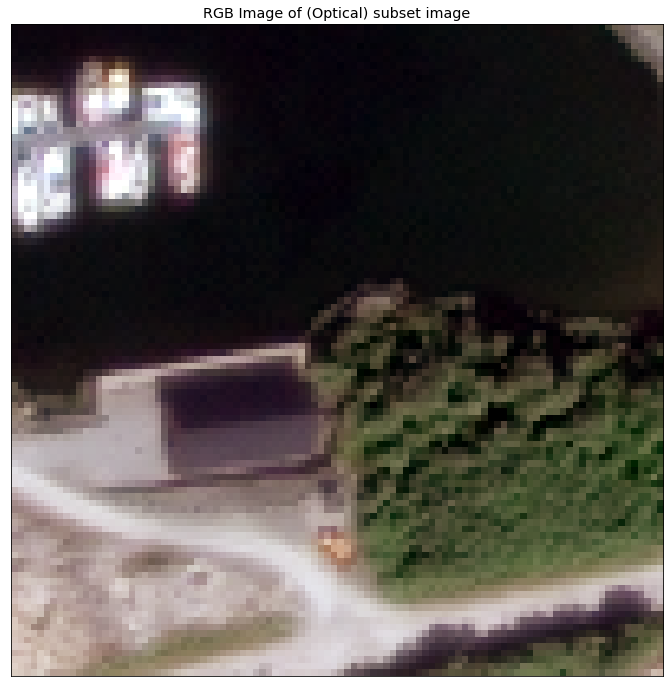

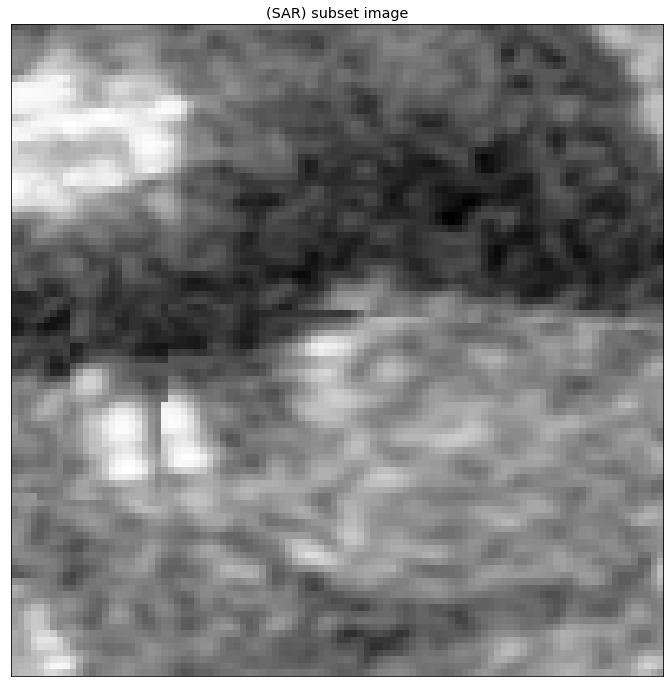

In [21]:
fig, ax = plt.subplots(figsize=(12, 12))
ep.plot_rgb(
    opt_subset,
    ax=ax,
    stretch=True,
    str_clip=0.5,
    title="RGB Image of (Optical) subset image",
)
plt.show()

ep.plot_bands(sar_subset, cbar=False, title="(SAR) subset image")
plt.show()

.


# Assign border/background to NoValue or NaN

**Problem**: Black border background (nodata) is represented by the value 0, but 0 is also used to define valid values within the dataset.  

Result from assigning "Nodata" the value 0 in **QGIS**: 

![](images/mislabeled-no-data.png)

However, internal pixels with value 0 seems to only apply to **one of the bands** (green):


|  R |  G |  B  |
|----|----|-----|
|  7 | 0  |  12 |  


  
   
**Solution**:  Use **mask** or apply `np.nan` whenever **all bands** are `0 0 0`


# Done

- Rescale/resize optical image to SAR resolution (1x1)
- Remove black pixels (nodata) outside both satellite images
    - SAR: Easy, no internal pixels with value `0`
    - Optical: Internal pixels with value `0`. Make sure all bands are `0 0 0` before assigning `np.nan`
- No repo/notebook for experimental paper



# TODO

- Split the images into smaller patches
- Incorporate ground truth (e.g., DTM, LiDAR) for vertical height
- Neural Network